## Prioritized DQN
&emsp;&emsp;在DQN训练算法中，通过经验回放机制来实时处理模型训练过程中得到的转移样本。该机制每次从样本池中等概率地抽取小批量的样本用于训练模型，这使得Agent无法区分出不同转移样本之间的重要性差异，对有价值样本的利用率不高。而且由于经验池的容量（如1000000）远远大于每次随机获取的小批量样本数（如32），这可能会导致一些重要样本被覆盖以及样本重复利用等问题。针对这些问题，Schaul等人提出一种基于优先级采样的深度Q网络（Prioritized Deep Q-Network，Prioritized DQN）方法。<br>
&emsp;&emsp;Prioritized DQN方法引入优先级回放（prioritized replay）机制，使用优先级采样方式替代原先的随机采样，提高了有价值转移样本被采样的概率，从而加快Agent学习最优策略的进程。另外，优先级经验回放机制还能在学习初期提高带有正奖赏转移样本的利用率，一定程度上缓解了在复杂问题中存在的稀疏奖赏问题。该算法不仅提高了收敛速度，并且在许多基于视觉感知的视频游戏任务中取得了更优的表现。<br>
&emsp;&emsp;Prioritized DQN算法核心在于：根据TD误差，将经验迁移样本按序存储在不同的经验池中。<br>
&emsp;&emsp;在小批量样本采样时，不再使用随机采样方法，而是根据需求从不同的经验池中选择迁移样本，这样TD误差越大的样本，被采样的次数可能越多。此外，新得到的经验样本会被设定为最大优先级样本，以保证它至少被训练一次，从而提高Agent的性能。下面主要阐述两种主要的经验回放机制。<br>
#### 优先级采样方法
&emsp;&emsp;（1）将具有不同奖赏量级的迁移序列分别存放在两个不同的回放记忆单元D1和D2中，其中D1用于存放带有正奖赏的、D2具有较高优先级的迁移序列；用于存放带有负奖赏或零奖赏的、具有较低优先级的迁移序列。<br>
&emsp;&emsp;（2）使用一种类似于分层抽样的方法从回放记忆单元中抽取固定数量（如32个）的迁移样本。具体的抽样方式是以概率p从回放记忆单元D1中抽取样本，以概率1-p从回放记忆单元D2中抽取样本。通过这种区别奖赏值量级大小的分层采样，提高了有价值的正奖赏迁移样本的利用率，从而促进了Agent的学习速度。<br>
&emsp;&emsp;（3）为缓解一部分迁移样本还未被利用就被回放记忆单元覆盖掉的问题，在迁移序列中增加了每个样本在训练过程中被采样的次数，即迁移样本的形式为。通常那些被频繁回放的转移样本具有较小的TD误差值，这是由于每一次回放都使得该样本所对应的Q值函数更加逼近目标动作值函数。在经验回放机制中，可以优先考虑那些很久未被采样到的迁移样本，因为这类样本对应的TD误差值较大。<br>
&emsp;&emsp;在基于离线样本的强化学习算法中，如果收集到的样本不能覆盖整体的样本空间，在某种程度上会导致学习的偏向性。而完全基于优先级的贪婪采样方式会使得转移样本缺乏多样性。具体地，基于优先级的贪婪采样方式倾向于收集那些具有较高优先级的转移样本，以避免扫描整个样本空间。不过该种抽样方式可能会使得一些具有较低优先级的样本失去被采样到的机会，从而导致对应的TD误差项更新过程过于缓慢。上述问题在使用深度神经网络来表示值函数时体现的尤为明显。因此有必要提出一种可以同时保证样本多样性和充分利用样本优先级的经验回放机制。<br>
#### 随机优先级方法
&emsp;&emsp;由于优先级采样会导致学习的偏向性，因此提出将随机采样与优先级采样相结合的随机优化方法。该方法可使得采样过程介于完全的优先级采样和随机采样之间，从而在优先利用有价值迁移样本的前提下，保证回放样本的多样性。为了使得迁移样本被采样的概率与对应的优先级成正比，并同时保证最低优先级对应的迁移样本具有非零的采样概率。<br>
&emsp;&emsp;采用优先级扫描的缺点在于，容易引起损失值发散问题，并产生偏差，但采用随机优先级和重要性采样方法可以减轻这些问题。总体来说，经验回放机制使得参数的更新不再受限于经验样本的顺序，优先级经验回放使算法不受限于经验样本的出现频率。<br>
#### Prioritized DQN算法
&emsp;&emsp;基于随机优先级的采样方式，提出一种基于随机优先级采样的深度Q学习算法（Deep Q-Learning with Prioritized Sampling，PS-DQN）。该算法将一种高效的优先级采样机制和深度Q学习算法相结合，一定程度上缓解了传统深度Q学习中有价值样本利用率不高的问题，提高了Agent在解决视觉感知决策问题时的性能和稳定性。<br>


In [1]:
import gym, random, pickle, os.path, math, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import pdb

from atari_wrappers import make_atari, wrap_deepmind
from IPython.display import clear_output
from tensorboardX import SummaryWriter

USE_CUDA = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

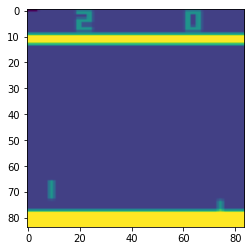

In [2]:
# Create and wrap the environment
env = make_atari('PongNoFrameskip-v4') # only use in no frameskip environment
env = wrap_deepmind(env, scale = False, frame_stack=True )
n_actions = env.action_space.n
state_dim = env.observation_space.shape

# env.render()
test = env.reset()
for i in range(100):
    test = env.step(env.action_space.sample())[0]

plt.imshow(test._force()[...,0])

#plt.imshow(env.render("rgb_array"))
# env.close()

In [3]:
class DQN(nn.Module):
    def __init__(self, in_channels=4, num_actions=5):
        """
        Initialize a deep Q-learning network as described in
        https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf
        Arguments:
            in_channels: number of channel of input.
                i.e The number of most recent frames stacked together as describe in the paper
            num_actions: number of action-value to output, one-to-one correspondence to action in game.
        """
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.fc5(x)


# 经验回放
DQN的经验回放采用均匀分布，而均匀分布采样并不能高效利用数据。因为agent的经验就是经历过的数据，但这些数据对于训练并不是具有同等重要的意义，agent在某些状态的学习效率比其他状态的学习效率高。<br>
优先回放的基本思想：打破均匀采样，赋予学习效率高的状态以更大的采样权重。<br>
如何选择权重？<br>
一个理想的标准是agent学习的效率越高，权重越大。TD偏差越大，说明该状态处的值函数与TD目标的差距越大，agent的更新量越大，因此该处的学习效率越高。<br>
如果TD-error越大, 就代表我们的预测精度还有很多上升空间, 那么这个样本就越需要被学习, 也就是优先级p越高。<br>
<center>$\theta_{t+1} = \theta_{t} + \alpha[r+\gamma{max_a^{'}Q(s^{'},a^{'};\theta^{'})-Q(s,a;\theta)}]\nabla{Q(s,a;\theta)}$<br></center>
有了 TD-error 就有了优先级 p, 那我们如何有效地根据 p 来抽样呢?<br>
如果每次抽样都需要针对 p 对所有样本排序, 这将会是一件非常消耗计算能力的事. 可以采用更高级的算法——SumTree方法。<br>
SumTree是一种树形结构，每片树叶存储每个样本的优先级P，每个树枝节点只有两个分叉，节点的值是两个分叉的和，所以SumTree的顶端就是所有p的和。<br>
<center><img src="./image/图1.png" height="400" width="500" ></center><br>
比如p的总和是42的话, 如果抽6个样本，划分成区间[0-7], [7-14], [14-21], [21-28], [28-35], [35-42]。然后在每个区间里随机选取一个数。<br>
(i)比如在区间 [21-28] 里选到了24, 就按照这个 24 从最顶上的42开始向下搜索.。<br>
(ii)首先顶端42 下面有两个子结点，先对比左边的子结点, 如果比24大, 那就走左边这条路。<br>
(iii)接着再对比 29 下面的左边子结点,13比24小, 那就走右边的路, 并且初始值24根据 13 修改, 变成 24-13 = 11。<br>
(iiii)接着拿着 11 和 16 左子结点比，12 比 11 大, 选 12 当做这次选到的 priority, 并且选择 12 对应的一条数据.<br>
简而言之，每次我们都选较大的节点数，因为每个父节点都是两个子节点的和，那么父节点较大的数也对应着较大的子节点数。<br>

In [4]:
# SumTree
# a binary tree data structure where the parent’s value is the sum of its children
class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1) #[]一维方程，数量为2 * capacity - 1 M0 = M2+1 M = M2+M0 M=2M0-1
        self.data = np.zeros(capacity, dtype=object)
        self.n_entries = 0

    # update to the root node 向上更新
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    # find sample on leaf node s为他的优先级 关键代码
    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    # store priority and sample
    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    # update priority
    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    # get priority and sample
    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])


In [5]:
class Memory_Buffer_PER(object):
    # stored as ( s, a, r, s_ ) in SumTree
    def __init__(self, memory_size=1000, a = 0.6, e = 0.01):
        self.tree =  SumTree(memory_size)
        self.memory_size = memory_size
        self.prio_max = 0.1
        self.a = a
        self.e = e
        
    def push(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        p = (np.abs(self.prio_max) + self.e) ** self.a #  proportional priority
        self.tree.add(p, data)

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        idxs = []
        segment = self.tree.total() / batch_size
        priorities = []

        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)
            s = random.uniform(a, b)
            idx, p, data = self.tree.get(s)
            
            state, action, reward, next_state, done= data
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
            priorities.append(p)
            idxs.append(idx)
        return idxs, np.concatenate(states), actions, rewards, np.concatenate(next_states), dones
    
    def update(self, idxs, errors):
        self.prio_max = max(self.prio_max, max(np.abs(errors)))  #为了让他保持一个p=0.1，不然容易不再探索这个动作了
        for i, idx in enumerate(idxs):
            p = (np.abs(errors[i]) + self.e) ** self.a
            self.tree.update(idx, p) 
        
    def size(self):
        return self.tree.n_entries


In [6]:
class DQN_PERAgent: 
    def __init__(self, in_channels = 1, action_space = None, USE_CUDA = False, memory_size = 10000, prio_a = 0.6, prio_e = 0.001, epsilon  = 1, lr = 1e-4):
        self.epsilon = epsilon
        self.action_space = action_space
        self.memory_buffer = Memory_Buffer_PER(memory_size, a = prio_a, e = prio_e)
        self.DQN = DQN(in_channels = in_channels, num_actions = action_space.n)
        self.DQN_target = DQN(in_channels = in_channels, num_actions = action_space.n)
        self.DQN_target.load_state_dict(self.DQN.state_dict())


        self.USE_CUDA = USE_CUDA
        if USE_CUDA:
            self.DQN = self.DQN.cuda()
            self.DQN_target = self.DQN_target.cuda()
        self.optimizer = optim.RMSprop(self.DQN.parameters(),lr=lr, eps=0.001, alpha=0.95)

    def observe(self, lazyframe):
        # from Lazy frame to tensor
        state =  torch.from_numpy(lazyframe._force().transpose(2,0,1)[None]/255).float()
        if self.USE_CUDA:
            state = state.cuda()
        return state

    def value(self, state):
        q_values = self.DQN(state)
        return q_values
    
    def act(self, state, epsilon = None):
        """
        sample actions with epsilon-greedy policy
        recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
        """
        if epsilon is None: epsilon = self.epsilon

        q_values = self.value(state).cpu().detach().numpy()
        if random.random()<epsilon:
            aciton = random.randrange(self.action_space.n)
        else:
            aciton = q_values.argmax(1)[0]
        return aciton
    
    def compute_td_loss(self,idxs, states, actions, rewards, next_states, is_done, gamma=0.99):
        """ Compute td loss using torch operations only. Use the formula above. """
        actions = torch.tensor(actions).long()    # shape: [batch_size]
        rewards = torch.tensor(rewards, dtype =torch.float)  # shape: [batch_size]
        is_done = torch.tensor(is_done,dtype = torch.uint8)  # shape: [batch_size]
        
        if self.USE_CUDA:
            actions = actions.cuda()
            rewards = rewards.cuda()
            is_done = is_done.cuda()

        # get q-values for all actions in current states
        predicted_qvalues = self.DQN(states)

        # select q-values for chosen actions
        predicted_qvalues_for_actions = predicted_qvalues[
          range(states.shape[0]), actions
        ]

        # compute q-values for all actions in next states
        predicted_next_qvalues = self.DQN_target(next_states) # YOUR CODE

        # compute V*(next_states) using predicted next q-values
        next_state_values =  predicted_next_qvalues.max(-1)[0] # YOUR CODE

        # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
        target_qvalues_for_actions = rewards + gamma *next_state_values # YOUR CODE

        # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
        target_qvalues_for_actions = torch.where(
            is_done, rewards, target_qvalues_for_actions)

        # mean squared error loss to minimize
        errors = (predicted_qvalues_for_actions - target_qvalues_for_actions).detach().cpu().squeeze().tolist()
        self.memory_buffer.update(idxs, errors)
        loss = F.smooth_l1_loss(predicted_qvalues_for_actions, target_qvalues_for_actions.detach())

        return loss
    
    def sample_from_buffer(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        idxs = []
        segment = self.memory_buffer.tree.total() / batch_size
        priorities = []

        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)
            s = random.uniform(a, b)
            idx, p, data = self.memory_buffer.tree.get(s)
            
            frame, action, reward, next_frame, done= data
            states.append(self.observe(frame))
            actions.append(action)
            rewards.append(reward)
            next_states.append(self.observe(next_frame))
            dones.append(done)
            priorities.append(p)
            idxs.append(idx)
        return idxs, torch.cat(states), actions, rewards, torch.cat(next_states), dones

    def learn_from_experience(self, batch_size):
        if self.memory_buffer.size() > batch_size:
            idxs, states, actions, rewards, next_states, dones = self.sample_from_buffer(batch_size)
            td_loss = self.compute_td_loss(idxs, states, actions, rewards, next_states, dones)
            self.optimizer.zero_grad()
            td_loss.backward()
            for param in self.DQN.parameters():
                param.grad.data.clamp_(-1, 1)

            self.optimizer.step()
            return(td_loss.item())
        else:
            return(0)
    

In [ ]:
# if __name__ == '__main__':
    
# Training DQN in PongNoFrameskip-v4 
env = make_atari('PongNoFrameskip-v4')
env = wrap_deepmind(env, scale = False, frame_stack=True)

gamma = 0.99
epsilon_max = 1
epsilon_min = 0.01
eps_decay = 30000
frames = 1000000
USE_CUDA = True
learning_rate = 2e-4
max_buff = 100000
update_tar_interval = 1000
batch_size = 32
print_interval = 1000
log_interval = 1000
learning_start = 10000
win_reward = 18     # Pong-v4
win_break = True

action_space = env.action_space
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]
state_channel = env.observation_space.shape[2]
agent = DQN_PERAgent(in_channels = state_channel, action_space= action_space, USE_CUDA = USE_CUDA, lr = learning_rate)

frame = env.reset()

episode_reward = 0
all_rewards = []
losses = []
episode_num = 0
is_win = False
# tensorboard
summary_writer = SummaryWriter(log_dir = "DQN_PER", comment= "good_makeatari")

# e-greedy decay
epsilon_by_frame = lambda frame_idx: epsilon_min + (epsilon_max - epsilon_min) * math.exp(
            -1. * frame_idx / eps_decay)
# plt.plot([epsilon_by_frame(i) for i in range(10000)])

for i in range(frames):
    epsilon = epsilon_by_frame(i)
    state_tensor = agent.observe(frame)
    action = agent.act(state_tensor, epsilon)
    
    next_frame, reward, done, _ = env.step(action)
    
    episode_reward += reward
    agent.memory_buffer.push(frame, action, reward, next_frame, done)
    frame = next_frame
    
    loss = 0
    if agent.memory_buffer.size() >= learning_start:
        loss = agent.learn_from_experience(batch_size)
        losses.append(loss)
 
    if i % print_interval == 0:        
        print("frames: %5d, reward: %5f, loss: %4f, epsilon: %5f, episode: %4d" % (i, np.mean(all_rewards[-10:]), loss, epsilon, episode_num))
        summary_writer.add_scalar("Temporal Difference Loss", loss, i)
        summary_writer.add_scalar("Mean Reward", np.mean(all_rewards[-10:]), i)
        summary_writer.add_scalar("Epsilon", epsilon, i)
        
    if i % update_tar_interval == 0:
        agent.DQN_target.load_state_dict(agent.DQN.state_dict())
    
    if done:
        
        frame = env.reset()
        
        all_rewards.append(episode_reward)
        episode_reward = 0
        episode_num += 1
        avg_reward = float(np.mean(all_rewards[-100:]))

summary_writer.close()
torch.save(agent.DQN.state_dict(), "trained model/DQN_PER_dict.pth.tar")

/home/ouyangz/.conda/envs/gym/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ouyangz/.conda/envs/gym/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


frames:     0, reward:   nan, loss: 0.000000, epsilon: 1.000000, episode:    0
frames:  1000, reward: -21.000000, loss: 0.000000, epsilon: 0.967544, episode:    1
frames:  2000, reward: -21.000000, loss: 0.000000, epsilon: 0.936152, episode:    2
frames:  3000, reward: -20.333333, loss: 0.000000, epsilon: 0.905789, episode:    3
frames:  4000, reward: -20.000000, loss: 0.000000, epsilon: 0.876422, episode:    4
frames:  5000, reward: -20.200000, loss: 0.000000, epsilon: 0.848017, episode:    5
frames:  6000, reward: -20.166667, loss: 0.000000, epsilon: 0.820543, episode:    6
frames:  7000, reward: -20.142857, loss: 0.000000, epsilon: 0.793971, episode:    7
frames:  8000, reward: -20.250000, loss: 0.000000, epsilon: 0.768269, episode:    8
frames:  9000, reward: -20.333333, loss: 0.000000, epsilon: 0.743410, episode:    9
frames: 10000, reward: -20.300000, loss: 0.029885, epsilon: 0.719366, episode:   10
frames: 11000, reward: -20.000000, loss: 0.045351, epsilon: 0.696110, episode:   

frames: 98000, reward: -17.500000, loss: 0.002015, epsilon: 0.047752, episode:   83
frames: 99000, reward: -17.500000, loss: 0.002614, epsilon: 0.046514, episode:   83
frames: 100000, reward: -17.300000, loss: 0.003183, epsilon: 0.045317, episode:   84
frames: 101000, reward: -17.300000, loss: 0.002667, epsilon: 0.044159, episode:   84
frames: 102000, reward: -16.900000, loss: 0.001951, epsilon: 0.043040, episode:   85
frames: 103000, reward: -16.900000, loss: 0.003351, epsilon: 0.041956, episode:   85
frames: 104000, reward: -16.900000, loss: 0.002546, epsilon: 0.040909, episode:   86
frames: 105000, reward: -16.900000, loss: 0.001628, epsilon: 0.039895, episode:   86
frames: 106000, reward: -16.700000, loss: 0.002948, epsilon: 0.038915, episode:   87
frames: 107000, reward: -16.700000, loss: 0.002607, epsilon: 0.037967, episode:   87
frames: 108000, reward: -16.700000, loss: 0.005571, epsilon: 0.037050, episode:   88
frames: 109000, reward: -16.700000, loss: 0.004036, epsilon: 0.0361

In [ ]:
def plot_training(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

plot_training(i, all_rewards, losses)